In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torch.utils.data import DataLoader
get_ipython().run_line_magic('matplotlib', 'inline')
from matplotlib import pyplot as plt
import matplotlib
import importlib as imp
import torch
import torch.optim as optim
import torch.nn as nn
import time
# from torchvision import transforms
from torch.utils.data import Dataset
import torch.nn.functional as F
import random
from sklearn.utils import shuffle
import os

get_ipython().run_line_magic('config', 'Completer.use_jedi = False')

In [2]:
EEG_PATH = 'data_EEG_AI.mat'

SEED = 344
Fs = 250 # 801 points for 3200ms -> 4ms -> 250Hz
times = [4 * t for t in range(0, 801)] #800 points for 3200ms -> 4ms for a points
K = 5 # for k-fold cross validation

n_samples = 7800 # number of total sample
n_letters = 300 # number of samples for a single letter
n_ch = 24 # number of channels in a sample
n_time = 801 # number of time points in a sample

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True # Fix the network according to random seed
    print('Finish seeding with seed {}'.format(seed))
    
seed_everything(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Training on device {}'.format(device))

Finish seeding with seed 344
Training on device cuda


In [4]:
def get_letter(label):
    return chr(ord('A') + label)


# # Get Data

In [9]:
from scipy.io import loadmat
data_mat = loadmat(EEG_PATH)
labels= data_mat['label'].squeeze(-1)
data = np.transpose(data_mat['data'], (2,0,1)) # original data is (24, 801, 7800), require (7800, 24, 801)
labels = labels - 1 # original label is 1-26, require 0-25
#del data_mat


# # M1 and M2 reference

In [11]:
# every channel minus the avrage of M1 and M2
ref_data = np.array([[curve - np.mean(np.array([curve for curve in data[i]]),axis=0) 
                      for curve in data[i]] for i in range(0, len(data))])


# # Dataset

In [12]:
#reverse
ref_data = np.array([[curve[::-1] for curve in ref_data[i]] for i in range(0, len(ref_data))])

In [7]:
#subsample
from scipy.ndimage import gaussian_filter1d
ref_data = np.array([[gaussian_filter1d([curve[67+idx//10] for idx in range(len(curve))], 5) for curve in ref_data[i]] for i in range(0, len(ref_data))])

In [7]:
#double
ref_data = np.array([[curve*2 for curve in ref_data[i]] for i in range(0, len(ref_data))])

In [15]:
#plus normalize
ref_data = np.array([[(curve - np.mean(np.array([curve for curve in data[i]]),axis=0))/np.std(np.array([curve for curve in data[i]]))
                      for curve in data[i]] for i in range(0, len(data))])

(7800, 24, 801)


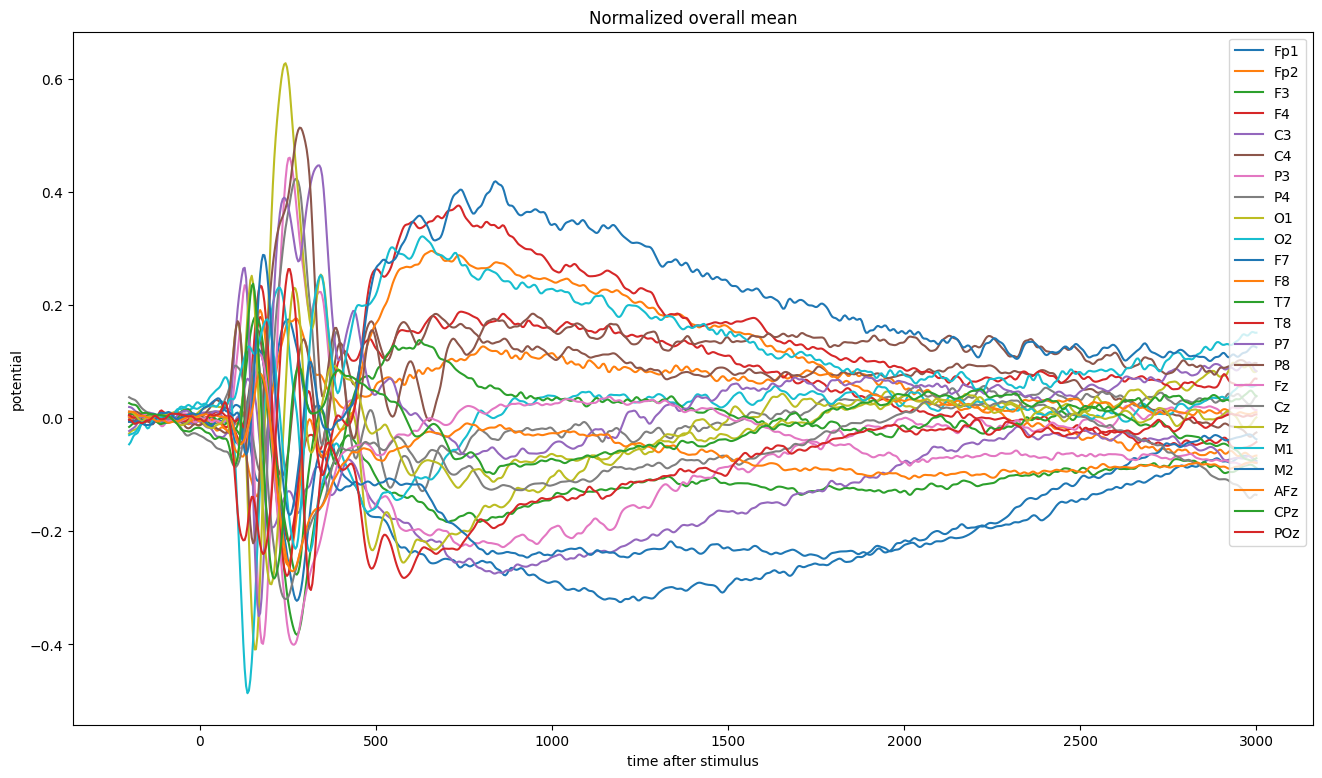

In [16]:
print(ref_data.shape)
plt.figure(figsize=(16,9))
plt.title(f"Normalized overall mean")
plt.ylabel("potential")
plt.xlabel("time after stimulus")
plot_data = np.transpose(ref_data, (1,2,0))
for ch in range(len(plot_data)):
    all = []
    for time in plot_data[ch]:
        all.append(sum(time)/7800)
    plt.plot(data_mat['time_points'][:,0],all, label=data_mat['channel_labels'][ch][0][0])
plt.legend(loc='best')
plt.show()

In [51]:
#pretrain

In [8]:
# split train and val and test dataset.
# Because the dataset require to average the data of same letter, shuffle must be done for each letter instead of the whole dataset.
def split_list(length, k=5):
    # Create 5-fold cv idx
    n = length // k
    idx_list = list(range(0, length))
    random.shuffle(idx_list)
    idx_list = np.array(idx_list)
    
    idx_kfold = np.stack([idx_list[i * n: (i + 1) * n] for i in range(0, k)])
    
    return idx_kfold

def split_letter(letter_data, idx_kfold):
    
    train_data = np.delete(letter_data, idx_kfold, 0)
    val_data = letter_data[idx_kfold]
    
    return np.array(train_data), np.array(val_data)

def split_data(data, idx_kfold, n=0):
    train_data = np.empty((0, n_ch, n_time), np.float32)
    val_data = np.empty((0, n_ch, n_time), np.float32)
    test_data = np.empty((0, n_ch, n_time),np.float32)
    for i in range(0, 26):
        train, val = split_letter(data[i * n_letters: (i+1) * n_letters], idx_kfold[n])
        train_data = np.append(train_data, train, axis=0)
        val_data = np.append(val_data, val, axis=0)
    return train_data, val_data

In [9]:
idx_kfold = split_list(n_letters, K)

In [10]:
train_data, val_data = split_data(ref_data, idx_kfold, 0)
train_data.shape, val_data.shape

((6240, 24, 801), (1560, 24, 801))

In [11]:
data_labels = np.concatenate([[i] * (n_letters - (n_letters // K)) for i in range(0, 26)], axis=0)
val_labels = np.concatenate([[i] * (n_letters // K) for i in range(0, 26)], axis=0)
data_labels.shape, val_labels.shape

((6240,), (1560,))

In [12]:
class EEGdataset(Dataset):
	
    def __init__(self, eeg, label, avr, device):
        self.eeg = eeg
        self.label = label
        self.device = device
        self.avr = avr

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        l = len(self.label) // 26
        letter = idx // l
        eeg_data = np.mean(self.eeg[letter*l + np.random.randint(l, size=(self.avr))], axis=0)
        
        if(self.avr == 1):
            eeg_tensor = torch.from_numpy(self.eeg[idx]).to(self.device)
        else:
            eeg_tensor = torch.from_numpy(eeg_data).to(self.device)
        #t = transforms.Compose([transforms.RandomResizedCrop(801,scale=(0.8,1.0))])
        #eeg_tensor = t(eeg_tensor)
        return eeg_tensor, torch.tensor(self.label[idx], dtype=torch.long).to(device)

In [13]:
from torch.utils.data import Dataset, DataLoader, random_split

batch_size = 4

eegtrainset = EEGdataset(train_data, data_labels, 300, device)
train_loader = DataLoader(eegtrainset, batch_size = batch_size, shuffle=True)

eegvalset = EEGdataset(val_data, val_labels, 1, device)
val_loader = DataLoader(eegvalset, batch_size = batch_size, shuffle=True)

tensor([25,  5,  7, 12], device='cuda:0')
torch.Size([4, 24, 801])


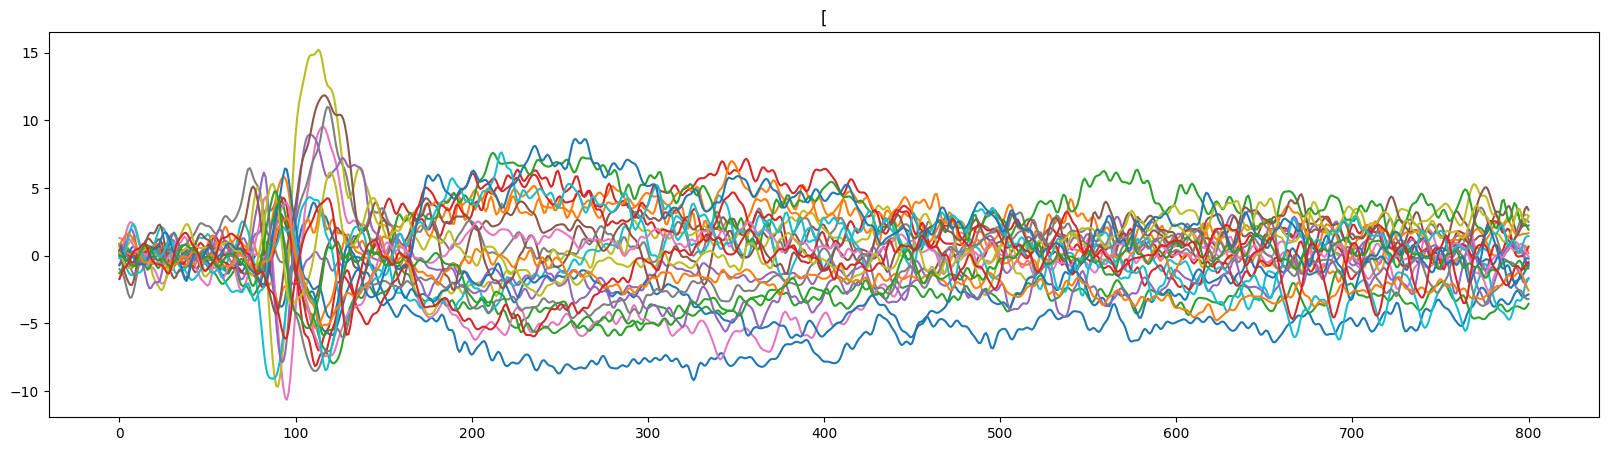

In [14]:
#plot a sample
eeg, label = next(iter(train_loader))
fig = plt.figure(figsize=(20, 5))
print(label)
print(eeg.shape)
plt.title(get_letter(label[0] + 1))
for curve in eeg.to('cpu')[0]:
    plt.plot(curve)


# # 1D CNN

In [15]:
momentum = 0.4
track_running_stats = True
affine = True
class NetCNN(nn.Module):
    def __init__(self, channels_in=24, channels_out=26):
        super().__init__()

        self.seq = nn.Sequential(
            nn.Conv1d(channels_in, 16, 1, padding=0),
            nn.BatchNorm1d(16, momentum=momentum, track_running_stats=track_running_stats, affine=affine),
            nn.ReLU(),
            nn.Conv1d(16, 32, 5, stride=3, padding=0),
            nn.BatchNorm1d(32, momentum=momentum, track_running_stats=track_running_stats, affine=affine),
            nn.ReLU(),
            nn.MaxPool1d(4, stride=2),
            nn.Conv1d(32, 64, 5, stride=2, padding=0),
            nn.BatchNorm1d(64, momentum=momentum, track_running_stats=track_running_stats, affine=affine),
            nn.ReLU(),
            nn.MaxPool1d(4, stride=2),
            nn.Conv1d(64, 48, 5, stride=2, padding=0),
            nn.BatchNorm1d(48, momentum=momentum, track_running_stats=track_running_stats, affine=affine),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(14 * 48, 80),
            nn.ReLU(),
            nn.Linear(80, channels_out)
        )
        
    def forward(self, x):
        x = self.seq(x)
        return x

In [16]:
#make confirm the datatype of model and the data are the same
data_type = eeg[0][0].dtype


# # Train

[33, 16, 11, 8, 6, 5, 4, 4, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 33, 16, 11, 8, 6, 5, 4, 4, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 33, 16, 11, 8, 6, 5, 4, 4, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 33, 16, 11, 8, 6, 5, 4, 4, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 33, 16, 11, 8, 6, 5, 4, 4, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1]


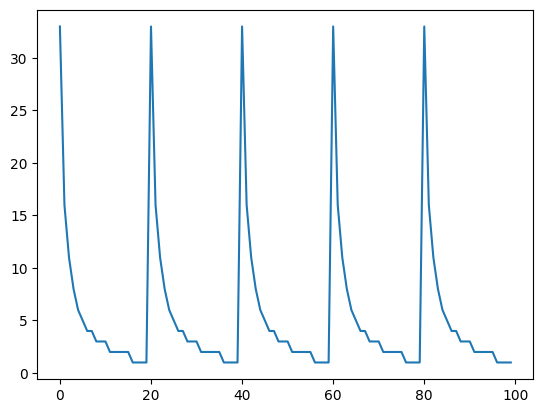

In [17]:
height = 100
steep = 3
def avr(height, steep, i):
    return np.max((round(height // (steep * (1 + i % 20))), 1))

#plot the curve of average numbers
plt.plot([avr(height, steep, i) for i in range (0, 100)])
#plt.plot([max(1, 30 - (i  % 20) * 3) for i in range (0, 100)])
print([avr(height, steep, i) for i in range (0, 100)])

In [18]:
def TrainClassifer(model,trn_data,val_dl,optimizer, scheduler=None,
                   n_eopchs=20, device='cpu', PATH = './best_acc.pt'):
    loss_fn = nn.CrossEntropyLoss()
    model.to(device)
    best_acc = 0.0
    metric = np.empty((0, 2), np.float32)

    for epoch in range(0, n_eopchs):
        loss_train = 0.0
        model.train()
        
        #train
        # build a new dataset and dataloader for each epoch
        trainset = EEGdataset(trn_data, data_labels, avr(height, steep, epoch), device)
        trn_loader = DataLoader(trainset, batch_size = batch_size, shuffle=True)
        
        for imgs, labels in trn_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            #outputs = model(imgs.unsqueeze(1))
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
            
        #validation
        loss_val = 0.0
        correct_val = 0.0
        model.eval()
        for _, (imgs, labels) in enumerate(val_dl):
            imgs = imgs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                outputs = model(imgs)
                #outputs = model(imgs.unsqueeze(1))
                loss = loss_fn(outputs, labels)
                loss_val += loss.item()
                
                correct_val += torch.sum(torch.argmax(outputs, dim=1) == labels)
                
        # record the best accuracy and save the model for best accuracy
        t_val_loss = (loss_val / len(val_dl))
            
        t_val_acc = (100 * correct_val / (len(val_dl) * val_dl.batch_size)).to('cpu').item()
        if t_val_acc > best_acc:
            best_acc = t_val_acc
            torch.save(model.state_dict(), PATH)
            
        if scheduler != None:
            scheduler.step()

        print('{} Eopch {}, Training Loss {}, Val Loss {}, Val Accuracy {}'.format(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime()),
                                                                  epoch + 1, loss_train / len(trn_loader), t_val_loss, 
                                                                                   t_val_acc))

        metric = np.append(metric, np.array([t_val_loss, t_val_acc]).reshape(1, 2), axis=0)
        
    print('Finish training: best_acc:{}'.format(best_acc))
    return metric, best_acc

In [ ]:
def PretrainClassifer(model,trn_data,val_dl,optimizer, scheduler=None,
                   n_eopchs=20, device='cpu', PATH = './best_acc.pt'):
    loss_fn = nn.CrossEntropyLoss()
    model.to(device)
    best_acc = 0.0
    metric = np.empty((0, 2), np.float32)

    for epoch in range(0, n_eopchs):
        loss_train = 0.0
        model.train()
        
        #train
        # build a new dataset and dataloader for each epoch
        trainset = EEGdataset(trn_data, data_labels, avr(height, steep, epoch), device)
        trn_loader = DataLoader(trainset, batch_size = batch_size, shuffle=True)
        
        for imgs, labels in trn_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            #outputs = model(imgs.unsqueeze(1))
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
            
        #validation
        loss_val = 0.0
        correct_val = 0.0
        model.eval()
        for _, (imgs, labels) in enumerate(val_dl):
            imgs = imgs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                outputs = model(imgs)
                #outputs = model(imgs.unsqueeze(1))
                loss = loss_fn(outputs, labels)
                loss_val += loss.item()
                
                correct_val += torch.sum(torch.argmax(outputs, dim=1) == labels)
                
        # record the best accuracy and save the model for best accuracy
        t_val_loss = (loss_val / len(val_dl))
            
        t_val_acc = (100 * correct_val / (len(val_dl) * val_dl.batch_size)).to('cpu').item()
        if t_val_acc > best_acc:
            best_acc = t_val_acc
            torch.save(model.state_dict(), PATH)
            
        if scheduler != None:
            scheduler.step()

        print('{} Eopch {}, Training Loss {}, Val Loss {}, Val Accuracy {}'.format(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime()),
                                                                  epoch + 1, loss_train / len(trn_loader), t_val_loss, 
                                                                                   t_val_acc))

        metric = np.append(metric, np.array([t_val_loss, t_val_acc]).reshape(1, 2), axis=0)
        
    print('Finish training: best_acc:{}'.format(best_acc))
    return metric, best_acc

In [19]:
N_epoch = 50 # training epoch for each fold
# Record the val loss/val accuracy and best accuracy
kfold_metric = np.empty((0, N_epoch, 2), np.float32)
kfold_acc = np.array([])
# Do k-fold training and validation
for k in range(0, K):
    train_data, val_data = split_data(ref_data, idx_kfold, k)
    eegvalset = EEGdataset(val_data, val_labels, 1, device)
    val_loader = DataLoader(eegvalset, batch_size = batch_size, shuffle=True)
    net = NetCNN(channels_in=n_ch, channels_out=26).to(device, data_type)
    optimizer = optim.SGD(net.parameters(), lr=2e-3)
    
    metric, best_acc = TrainClassifer(net, train_data, val_loader, optimizer, scheduler=None,
                                      n_eopchs=N_epoch, device=device, PATH=''.join(['./best_', str(k), '.pt']))
    kfold_metric = np.concatenate([kfold_metric, metric.reshape(1, -1, 2)], axis=0)
    kfold_acc = np.append(kfold_acc, best_acc)


# # Result

2024-02-13 03:00:25 Eopch 1, Training Loss 3.032865270353114, Val Loss 5.872036635263164, Val Accuracy 5.0
2024-02-13 03:00:36 Eopch 2, Training Loss 2.480158375561027, Val Loss 7.222424925475969, Val Accuracy 5.705128192901611
2024-02-13 03:00:46 Eopch 3, Training Loss 1.9241720909678262, Val Loss 8.461903278801962, Val Accuracy 5.705128192901611
2024-02-13 03:00:54 Eopch 4, Training Loss 1.6095319210200112, Val Loss 7.086586401284436, Val Accuracy 6.538461685180664
2024-02-13 03:01:00 Eopch 5, Training Loss 1.584161725129004, Val Loss 6.1806848712814, Val Accuracy 8.14102554321289
2024-02-13 03:01:05 Eopch 6, Training Loss 1.5581617078775816, Val Loss 5.607102718874806, Val Accuracy 8.525641441345215
2024-02-13 03:01:11 Eopch 7, Training Loss 1.6418293733407532, Val Loss 4.9134600884890265, Val Accuracy 9.230769157409668
2024-02-13 03:01:17 Eopch 8, Training Loss 1.5032995662337025, Val Loss 5.364076284361399, Val Accuracy 10.256410598754883
2024-02-13 03:01:22 Eopch 9, Training Loss

In [20]:
# Print the result
print("Result of k-fold cross validation:")
for k in range(0, K):
    print("Best Accuracy(%) for Fold {}: {}".format(k+1, kfold_acc[k]))
print()
print("Best Accuracy(%) in total: {}".format(np.max(kfold_acc)))
print("Average Accuracy(%) in total: {}".format(np.mean(kfold_acc)))


Result of k-fold cross validation:
Best Accuracy(%) for Fold 1: 15.0
Best Accuracy(%) for Fold 2: 14.807692527770996
Best Accuracy(%) for Fold 3: 14.743590354919434
Best Accuracy(%) for Fold 4: 15.512821197509766
Best Accuracy(%) for Fold 5: 16.346155166625977

Best Accuracy(%) in total: 16.346155166625977
Average Accuracy(%) in total: 15.282051849365235


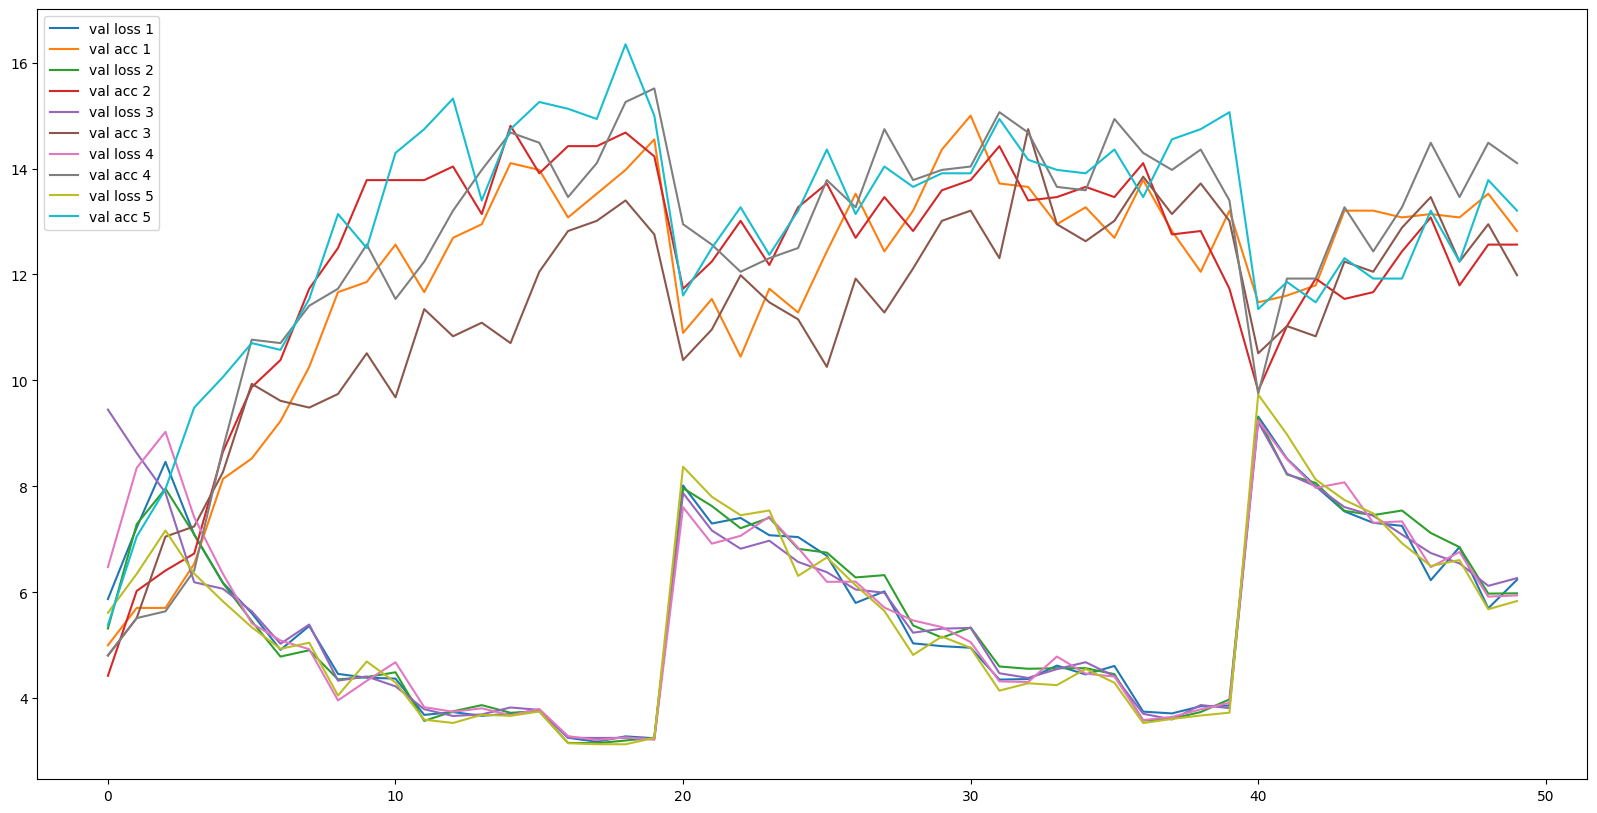

In [21]:
# Plot the curve of val loss / accuracy
plt.figure(figsize=(20,10))
legend = ['val loss 1', 'val acc 1',
          'val loss 2', 'val acc 2',
          'val loss 3', 'val acc 3',
          'val loss 4', 'val acc 4',
          'val loss 5', 'val acc 5']
for i in range(0, K):
    for j in range(0, 2):
        plt.plot(kfold_metric[i, :, j], label = legend[i*2 + j])
plt.legend()